# SOMPZ
### The purpose of this notebook is to take a wide, deep and balrog catalogs and create N(z)'s

### 1. Load packages

In [1]:
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import scipy
from scipy.optimize import differential_evolution
from matplotlib.colors import LogNorm
outpath = '/project/chihway/raulteixeira/data/'
n_deep, n_wide = 48, 26
nbins = 120
zmin, zmax = 0., 6.
deltaz = zmax/nbins
assert ( (zmin>=0) & (zmax>=zmin) & (nbins>0) & (n_deep>0) & (n_wide>0) )
z_edges = np.arange(zmin,zmax,deltaz)#np.linspace(zmin,zmax,nbins)
zs = .5*np.array([z_edges[i]+z_edges[i+1] for i in range(nbins-1)])

### 2. load functions

In [2]:
#add descriptions to functions!!!

def hist(a):
    '''
    Returns the counts of each bin in a histogram of sample a (numerical list-like object)
    '''
    return list(np.histogram(a, bins=z_edges, density=False)[0])

def flux2mag(flux):
    '''
    Converts fluxes to magnitudes
    '''
    return -2.5 * np.log10(flux) + 30

### 3. Load relevant catalogs (wide, deep, balrog), apply relevant cuts and add relevant columns

In [3]:
wide = np.load('%sBPZ+SOM_mcal_gold_wide_26x26_ids+cells+fluxes.npz'%outpath)['arr_0']
# opens .npz containing BPZ estimates, wide SOM cell assignments, ids, and fluxes. 
# Catalog has foreground, wl selection, and gold cut applied already.
wide = pd.DataFrame(wide) #convert to pandas dataframe for easier data manipulation
wide['wide_cells']=wide['cells'] #rename 'cells' column for easier identification
wide.drop(columns=['cells']) #see comment above

,COADD_OBJECT_ID,FLUX_R,FLUX_ERR_R,FLUX_I,FLUX_ERR_I,FLUX_Z,FLUX_ERR_Z,CHI_SQ,ID,M_0,...,T_B,T_ML,Z_B,Z_B_MAX,Z_B_MIN,Z_MEAN,Z_ML,Z_SAMP,Z_SIG,wide_cells
0,7109304883,3697.074912,41.510975,4342.987764,49.896796,5399.346127,101.126423,0.572120,7109304883,20.794094,...,5.0,5.0,0.155,0.215000,0.097571,0.193081,0.165,0.445,0.163029,8
1,7109304892,1060.265660,32.105632,2483.591726,41.284574,3354.406431,87.896135,1.192293,7109304892,21.408283,...,2.0,2.0,0.775,0.863257,0.555000,0.709006,0.775,0.835,0.105364,590
2,7109304896,2632.422146,45.376178,3391.575227,68.988487,4295.313674,125.899520,0.326125,7109304896,21.130915,...,5.0,5.0,0.435,0.506352,0.285000,0.399023,0.365,0.455,0.104050,137
3,7109304898,2133.722123,38.464039,2287.077329,46.422072,3271.006405,99.938773,0.463370,7109304898,21.517611,...,5.0,5.0,0.365,0.435000,0.297129,0.388183,0.365,0.375,0.051087,133
4,7109304902,751.718904,53.678323,992.224432,54.098644,1250.526081,120.534894,0.008982,7109304902,22.695087,...,4.0,3.0,0.485,0.685000,0.285000,0.503720,0.215,0.315,0.209248,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47341771,7238533745,314.153069,18.548237,505.979069,56.803356,633.341440,131.662368,0.567029,7238533745,23.360582,...,5.0,5.0,0.805,1.035000,0.625000,0.826410,0.795,1.475,0.265486,437
47341772,7238533748,964.399538,15.952696,1356.360993,43.581431,1415.369620,57.492529,0.093127,7238533748,22.206959,...,5.0,2.0,0.515,0.590330,0.265000,0.429240,0.175,0.515,0.131464,93
47341773,7238533765,911.598527,10.944956,1507.449772,39.471370,1832.381211,56.297044,1.375936,7238533765,22.136280,...,4.0,2.0,0.715,0.800274,0.605000,0.680019,1.995,0.715,0.060506,490
47341774,7238533780,833.704984,11.755467,1079.063185,40.732953,821.096510,69.823689,0.590451,7238533780,22.400141,...,4.0,3.0,0.245,0.555000,0.183095,0.374921,0.015,0.265,0.192955,99


In [4]:
deep_cells = np.load('%s/som_DES_DF_balrog_gold+wl+fg_112623_48x48.npz'%outpath)['cells']
deep = pd.read_hdf('%s/deep_Balrog_DR3_1_1_fp_GOLD_WL_FG.hdf5'%outpath, key='df')
deep['deep_cells'] = deep_cells

In [5]:
deep.to_hdf('%s/deep_Balrog_DR3_1_1_fp_GOLD_WL_FG_deep_cells.hdf5'%outpath, key='df')

In [6]:
np.isfinite(deep['Z']).sum()

55084

In [7]:
balrog = pd.read_hdf('%s/BalrogoftheDECADE_112523_wide_cells.hdf5'%outpath, key='df')
balrog_mask = np.load('/project/chihway/raulteixeira/data/Balrog_20231125_MASK_GOLD+WL+FG.npz')['arr_0']

# zeroth order masks
balrog_fg_mask = balrog['FLAGS_FOREGROUND']==0
d_contam_arcsec  = balrog['d_contam_arcsec']
contmask = (d_contam_arcsec > 1.5) 
balrog['contmask'] = contmask
balrog_fp_mask = (balrog['true_ra'] < 180) & (balrog['true_dec'] > -25) #footprint mask for DR3_1_1

usable_balmask = balrog_fg_mask&contmask&balrog_fp_mask
# add balrog dr3_1_1 footprint cut

print(f'fraction of usable balrog injections that pass the gold cut and WL selection:\
      {np.mean(balrog_mask[usable_balmask]):.2}')

balrog = balrog[usable_balmask] #applying DR3_1_1 footprint mask, contamination mask
balrog_mask_test = balrog_mask[usable_balmask]

fraction of usable balrog injections that pass the gold cut and WL selection:      0.22


In [8]:
balrog['passes'] = balrog_mask[usable_balmask]
print(len(balrog)) #length of balrog after usable mask

balrog_deep = balrog.merge(deep, on='ID', how='left') # merge balrog w/ deep catalog for later
                                                      # will have same length as barlog catalog

3760727


In [9]:
for band in list('UGRIZJH')+['KS']:

    fluxcol = f'BDF_FLUX_DERED_CALIB_{band}'
    fluxerrcol = f'BDF_FLUX_ERR_DERED_CALIB_{band}'
    
    magcol = f'BDF_MAG_DERED_CALIB_{band}'
    magerrcol = f'BDF_MAG_ERR_DERED_CALIB_{band}'

    deep[magcol]=flux2mag(deep[fluxcol])
    deep[magerrcol]=flux2mag(deep[fluxerrcol])

### contaminant cut (moved to where the balrog cat. is loaded)

### estimating the probability of a given galaxy in the deep fields making a detection
* Note here that we are obtaining 'counts_dec' not with 'detected' column but with gold cut (double check this is correct!)

In [10]:
unique_ids, counts_true = np.unique(balrog.ID.values, return_counts=True) 
# how many injections for each DF galaxy were made

unique_ids_detected, counts_detected = np.unique(balrog.ID.values[balrog.passes.values], return_counts=True)
# how many gold "detections" for each DF galaxy were made

# pandas to simplify life
df0 = pd.DataFrame()
df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()
df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left') 
# merge on id, this dataframe, df_, will have length equal to 
# the number of DF galaxies being used for balrog injections

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed, 
                                                   # I can probably do this on the array to not get a warning

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] 
#p(\hat{c}) i.e., probability of passing for a given DF galaxy

balrog = balrog.merge(df_[['ID', 'p_pass']], on='ID') 
# merging to have everything under balrog and be able
# to make cell statistics of the columns generated in this cell

/tmp/jobs/31391541/ipykernel_286496/407432572.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed,


### Create and marginalize probabilities to obtain Balrog Transfer Matrix

In [11]:
# !!!

# *Relevant* for this cell: section 5 and Appendix D in Myles, Alarcon, et. al 2021

#p(c) - i.e. probability that a galaxy in the deep fields will belong to a cell c
square_len_deep = balrog_deep[['BDF_FLUX_DERED_CALIB_I', 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
counts_deep = square_len_deep.BDF_FLUX_DERED_CALIB_I.len
p_c = (counts_deep/counts_deep.sum()).values.reshape(n_deep,n_deep)

#square_wide = wide['wide_cells'].groupby('wide_cells').agg(['mean', 'median', 'std', len])

#p(\hat{c}) - i.e. probability that a galaxy in the wide fields will belong to a cell c 
square_p_c_hat = wide[['COADD_OBJECT_ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide = square_p_c_hat.COADD_OBJECT_ID.len

#p^W(\hat{c}) - Wide field version
p_c_hat = counts_wide.values.reshape(n_wide,n_wide)
p_c_hat = p_c_hat/np.sum(p_c_hat)

#p^B(\hat{c}) - Balrog version - see if detection masking is appropriate here 
                                # that is, should we include this or not? [balrog.detected.values.astype(bool)]
square_p_c_hat_bal = balrog[balrog.passes.values&balrog.detected.values.astype(bool)][['ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide_bal = square_p_c_hat_bal.ID.len

p_c_hat_bal = counts_wide_bal.values.reshape(n_wide,n_wide).astype(np.float64)
p_c_hat_bal /= np.sum(p_c_hat_bal)

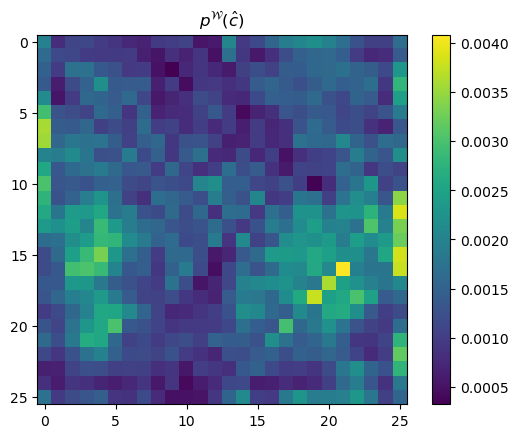

In [12]:
plt.title('$p^{\mathcal{W}}(\hat{c})$')
plt.imshow(p_c_hat)
plt.colorbar()

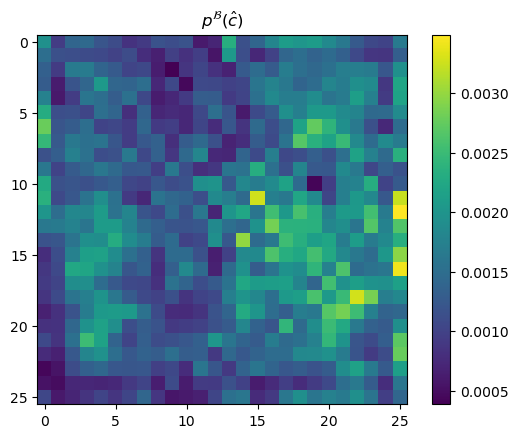

In [13]:
plt.title('$p^{\mathcal{B}}(\hat{c})$')
plt.imshow(p_c_hat_bal)
plt.colorbar()

In [15]:
#p(c,\hat{c}) - joint probability of a galaxy in balrog_deep being in cell c and \hat{c}
N_wide, N_deep = 26**2, 48**2
#sel_mask = balrog_deep.detected&balrog_deep.passes&balrog_deep['contmask'].values&\
#(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

sel_mask = balrog_deep.passes&balrog_deep.detected&(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

unique_ids, index, rev_index, counts_true =\
np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

InjDF = pd.DataFrame({'ID': balrog_deep.ID.values[index], # Credit: Alex Alarcon 
'wide_cell': balrog_deep.wide_cells.values[index],        # You can display this dataframe to see what it is,
'deep_cell': balrog_deep.deep_cells.values[index],        # but in a nutshell, it will tell you how many times
'N_inj':counts_true})                                     # a given DF galaxy (see 'ID' column) was injected into
                                                          # the footprint
p_cchat = np.zeros((N_wide, N_deep)) # Credit: Alex Alarcon 
np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask[index]].astype(int),\
                    InjDF.deep_cell.values[sel_mask[index]].astype(int)), 1.0 /\
          InjDF.N_inj.values[sel_mask[index]]) # what this should do:
# get the joint c, c_hat probability as 
# p(c, c_hat) = (number of detections)/(number_injections) 
# for all injections falling into each pair (c, c_hat)

#p(c)p(\hat{c})
p_c_p_c_hat = np.multiply.outer(p_c_hat_bal.flatten(), p_c.flatten())
#(p_c.flatten() * np.repeat(p_c_hat_bal, n_deep**2).reshape(n_deep**2, n_wide**2).T)
#p_c horizontal and p_c_hat vertical

balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

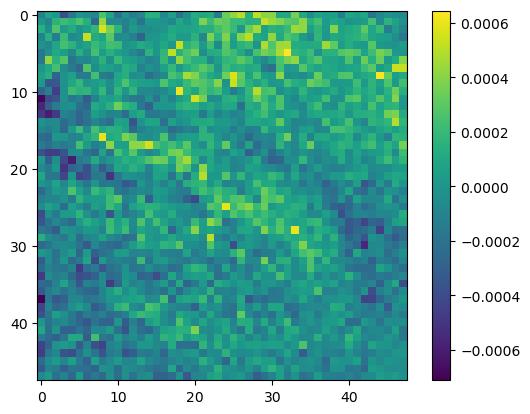

In [16]:
#testing whether these match
p_c_marg = np.sum(p_cchat, axis=0)#.reshape(n_deep,n_deep)
p_c_marg /= np.sum(p_c_marg)

p_c_norm = p_c/np.sum(p_c)#[:,None]

plt.imshow((p_c_marg-p_c_norm.flatten()).reshape(n_deep,n_deep))
plt.colorbar()

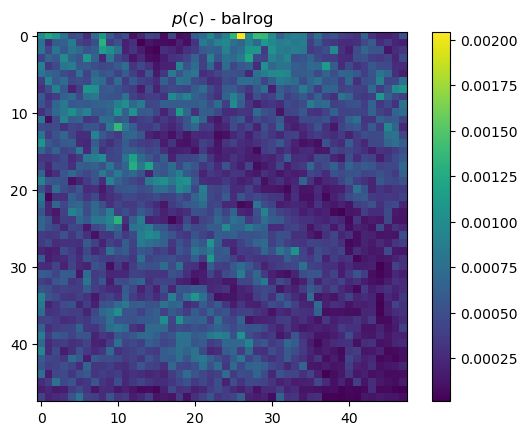

In [17]:
plt.title('$p(c)$ - balrog')
plt.imshow(p_c_marg.reshape(n_deep,n_deep))
plt.colorbar()

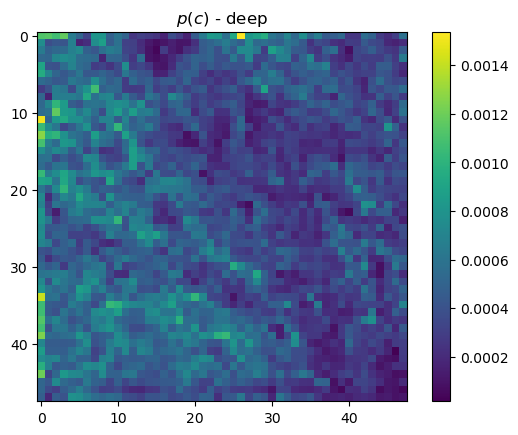

In [14]:
plt.title('$p(c)$ - deep')
plt.imshow(p_c)
plt.colorbar()

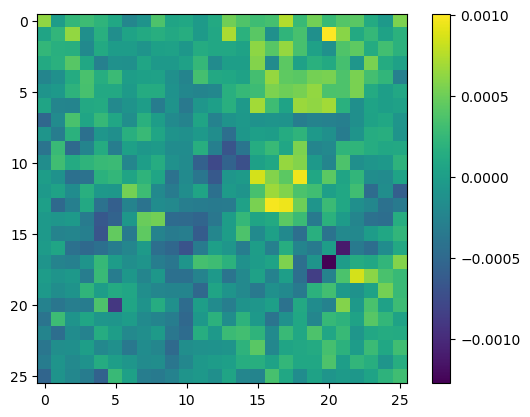

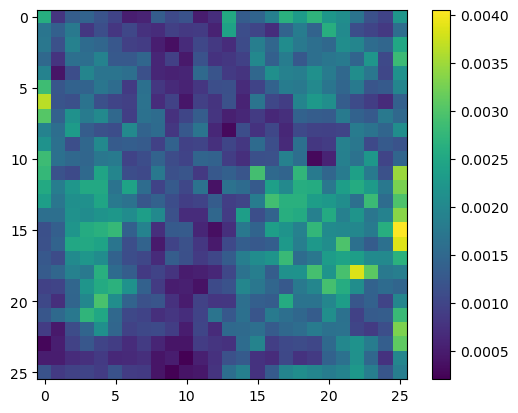

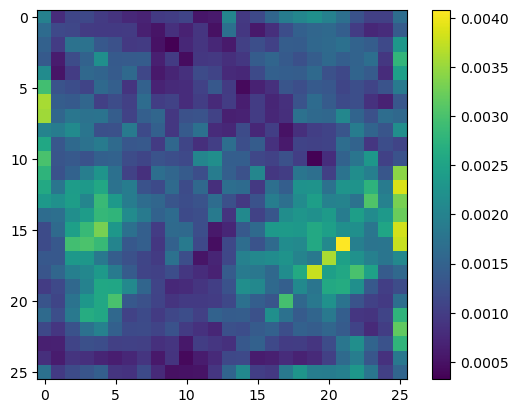

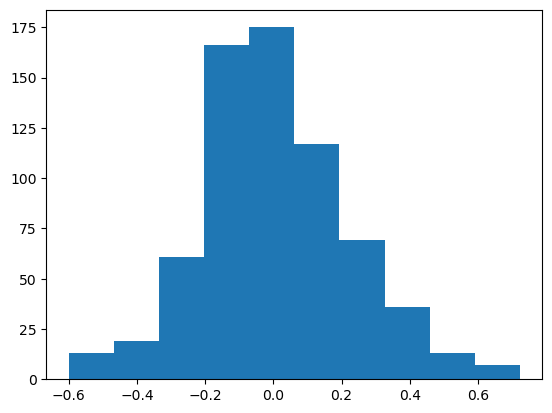

In [26]:
#testing whether these match
p_c_hat_marg = np.sum(p_cchat, axis=1)
p_c_hat_marg /= np.sum(p_c_hat_marg)

p_c_hat_norm = p_c_hat/np.sum(p_c_hat)

plt.imshow((p_c_hat_marg-p_c_hat_norm.flatten()).reshape(n_wide,n_wide))
plt.colorbar()
plt.show()
plt.imshow((p_c_hat_marg.flatten()).reshape(n_wide,n_wide))
plt.colorbar()
plt.show()
plt.imshow((p_c_hat_norm.flatten()).reshape(n_wide,n_wide))
plt.colorbar()
plt.show()
plt.hist((p_c_hat_marg-p_c_hat_norm.flatten())/(p_c_hat_norm.flatten()))
plt.show()

### $p(z|\hat{c}) = \sum_{c} p(z|c) p(c) \dfrac{p(c,\hat{c})}{p(c)p(\hat{c})} p(\hat{c})$

In [27]:
#cell weights
joint_cell_weight = p_c.flatten() * balrog_term * p_c_hat.flatten()[:,None]

#p(z,c)
cell_z = deep[['Z', 'deep_cells']].groupby('deep_cells').agg(func=hist)
p_z_c = np.array([cell_z['Z'][cell] for cell in cell_z['Z'].index])

zero_mask = np.sum(p_z_c, axis=1)==0
rangedeep = np.arange(0, n_deep**2)
nonzero_indices = rangedeep[~zero_mask]

p_z_c = p_z_c[nonzero_indices].astype('float64')
p_z_c /= np.sum(p_z_c, axis=1)[:,None]

#inner sum result of eq. 14 in Myles, Alarcon
p_z_c_hat = (joint_cell_weight[:,nonzero_indices]@p_z_c) #check if should be normalized

p_z_c_hat /= np.sum(p_z_c_hat, axis=1)[:,None]

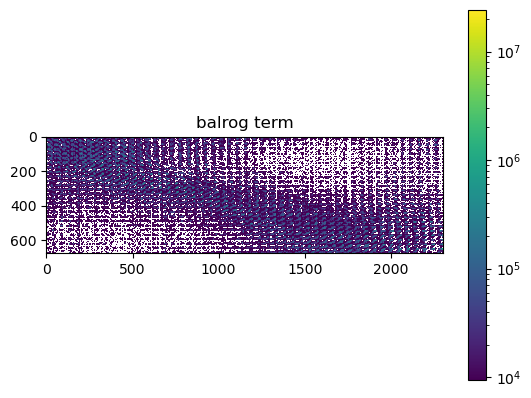

In [28]:
plt.title('balrog term')
plt.imshow(balrog_term, norm=LogNorm())
plt.colorbar()

/tmp/jobs/31391541/ipykernel_286496/2104998275.py:4: RuntimeWarning: invalid value encountered in divide
  plt.imshow(p_z_c_hat/np.sum(p_z_c_hat, axis=0), norm=LogNorm())


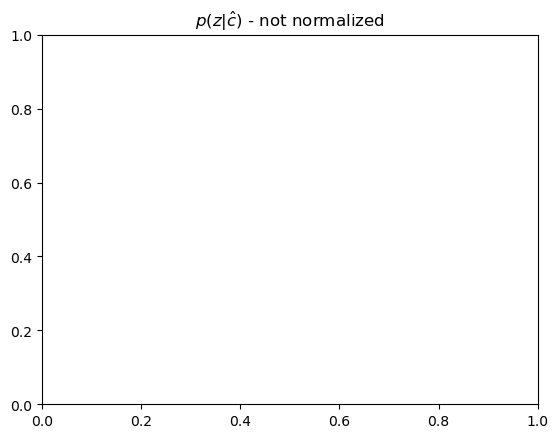

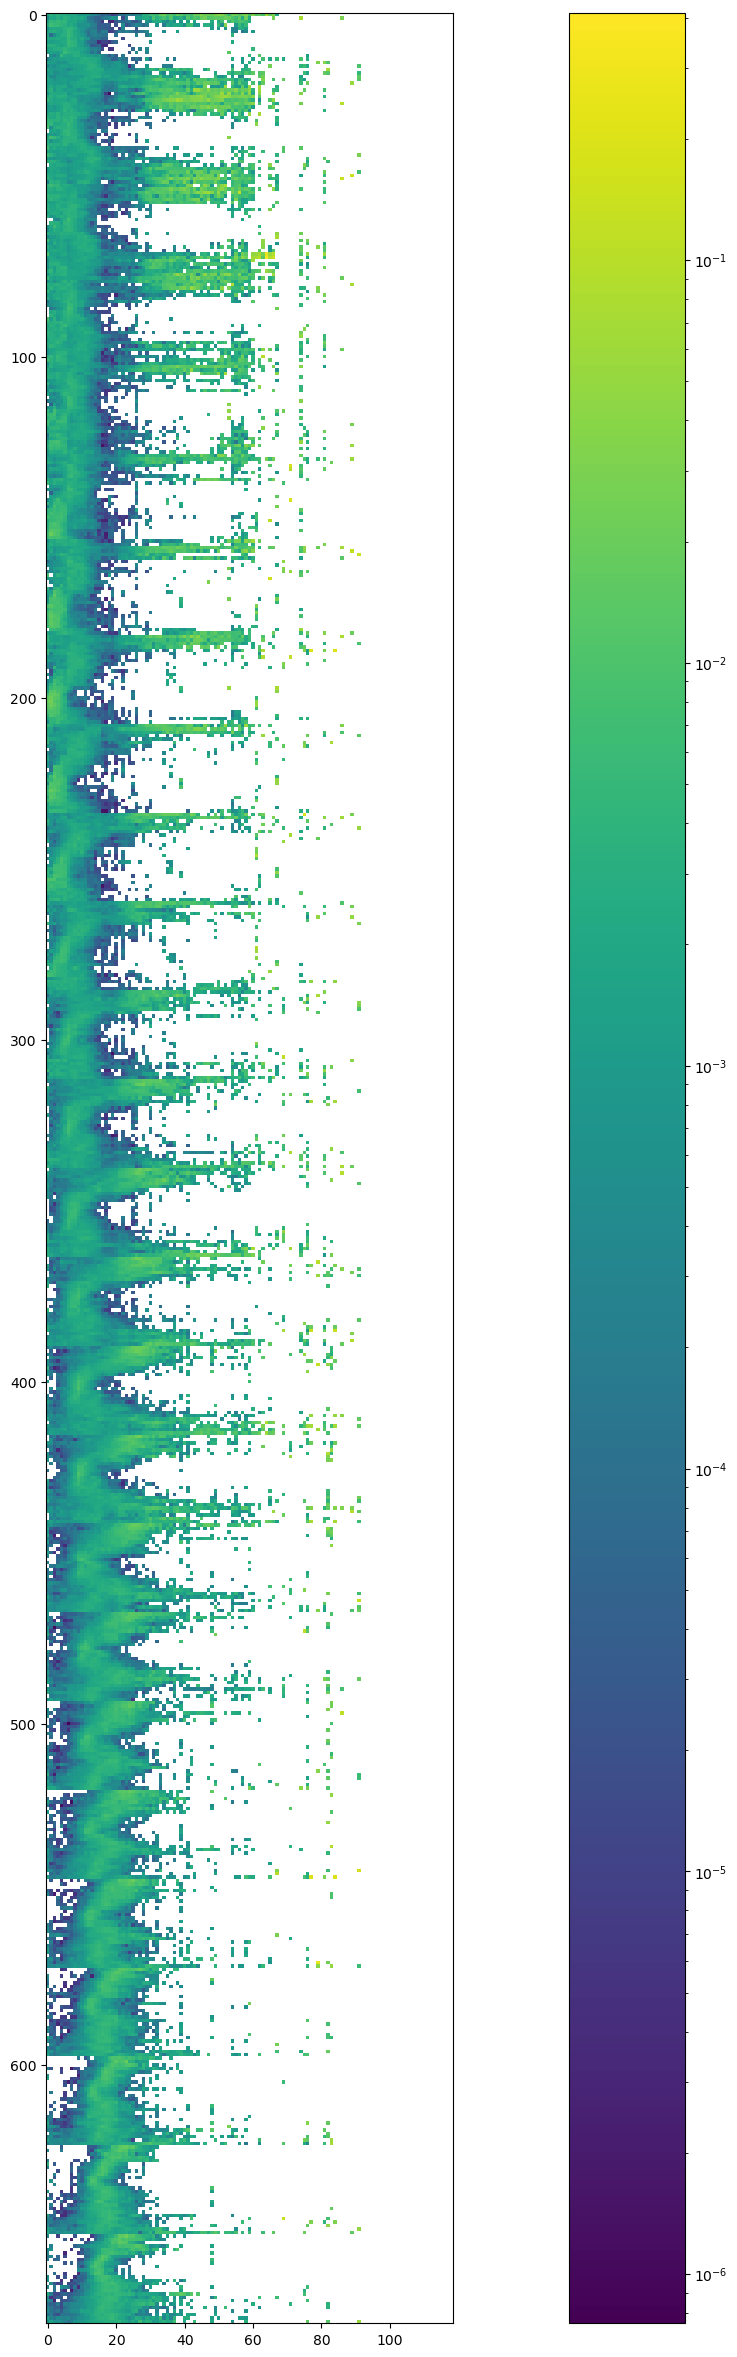

In [ ]:
from matplotlib.colors import LogNorm
plt.title('$p(z|\hat{c})$ - not normalized')
plt.figure(figsize=(30,30))
plt.imshow(p_z_c_hat/np.sum(p_z_c_hat, axis=0), norm=LogNorm())
plt.colorbar()

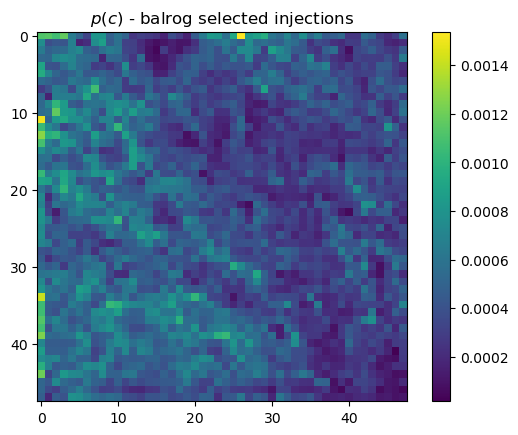

In [30]:
plt.title('$p(c)$ - balrog selected injections')
plt.imshow(p_c)
plt.colorbar()

### Binning algorithm described in Myles, Alarcon 2021

In [31]:
#bins_0 = np.concatenate(([0], np.random.normal([0.358, 0.631, 0.872], scale=.03), [2]))
bins_0 = np.concatenate(([0], [0.358, 0.631, 0.872], [2]))
bins_0 = np.round(bins_0, decimals=3)

In [71]:
def bin_loss(bins=bins_0):
    bins = np.concatenate(([0], bins, [2]))
    bin_masks = [(bins[i]<zs)&(zs<bins[i+1]) for i in range(4)]
    tb_assign = np.argmax(np.array([np.sum(p_z_c_hat[:,bin_mask], axis=1) for bin_mask in bin_masks]), axis=0)
    tb_norm_counts = np.array([np.sum(p_c_hat.flatten()[tb_assign==i]) for i in range(4)])
    #return (np.mean(tb_norm_counts)-.25)**2+np.std(tb_norm_counts)
    return np.sum(np.abs(tb_norm_counts - 0.25))#+np.var(tb_norm_counts)

In [35]:
def tb_share(bins=bins_0):
    #bins = np.concatenate(([0], bins, [2]))
    print()
    bin_masks = [(bins[i]<zs)&(zs<bins[i+1]) for i in range(4)]
    tb_assign = np.argmax(np.array([np.sum(p_z_c_hat[:,bin_mask], axis=1) for bin_mask in bin_masks]), axis=0)
    tb_norm_counts = [np.sum(p_c_hat.flatten()[tb_assign==i]) for i in range(4)]
    return tb_norm_counts

In [75]:
loss_curr = np.inf
best_bins = bins_0
for i in range(10):
    bins_0 = np.random.normal([0.358, 0.631, 0.872], scale=.1)

    n_bins = 4
    result_DE = differential_evolution(bin_loss, bounds=[(0,2), (0,2), (0,2)], x0=bins_0)
    bins = result_DE.x
    
    if result_DE.fun<loss_curr:
        loss_curr = result_DE.fun
        best_bins = bins
print(loss_curr)

best_bins

0.10185245268365095


array([0.3584524 , 0.53398655, 0.85195745])

In [76]:
best_bins

array([0.3584524 , 0.53398655, 0.85195745])

In [77]:
bins_0 = np.random.normal([0.358, 0.631, 0.872], scale=.1)

n_bins = 4
result_DE = differential_evolution(bin_loss, bounds=[(0,zmax), (0,zmax), (0,zmax)], x0=bins_0)
bins = result_DE.x
print(result_DE)

 message: Optimization terminated successfully.
 success: True
     fun: 0.10185245268365095
       x: [ 3.525e-01  5.615e-01  8.267e-01]
     nit: 33
    nfev: 1534


[0.         0.3584524  0.53398655 0.85195745 2.        ]


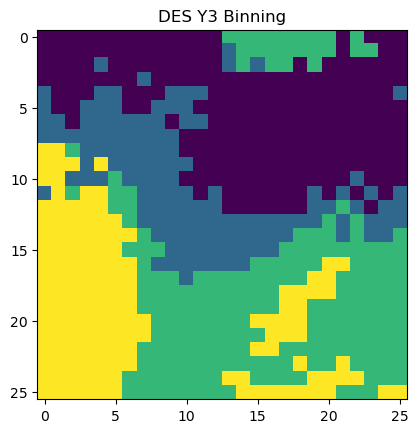

In [78]:
#bins = differential_evolution(bin_loss, bounds=[(0,0), (0,1), (0,1), (2,2)], x0= [0, 0.4, 0.8, 2]).x
bins = np.concatenate(([0], best_bins, [2]))
#bins=[0.000e+00,  4.230e-01,  6.738e-01,  9.931e-01,  2.000e+00]
bin_masks = [(bins[i]<zs)&(zs<bins[i+1]) for i in range(n_bins)]
bin_masks = [np.tile(bin_masks[i], n_wide**2).reshape(n_wide**2, nbins-1) for i in range(n_bins)]

tb_test = np.array([np.sum(p_z_c_hat[bin_masks[i]].reshape(n_wide**2, bin_masks[i][0].sum()), axis=1) for i in range(n_bins)])

tomo_bins = np.argsort(tb_test.T)[:,-1]

#np.savez('/project/chihway/raulteixeira/data/TomoBins_DESY3_Algo_DELVE_DR3_1_1.npz', tomo_bins)
print(bins)
plt.title('DES Y3 Binning')
plt.imshow(tomo_bins.reshape(n_wide, n_wide))

In [79]:
cell_masks = [tomo_bins==i for i in range(n_bins)]

p_z_c_hat_bins = np.array([np.sum(p_z_c_hat[cell_masks[i]], axis=0) for i in range(n_bins)])

print('mean z per bin', [np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * zs)\
       for i in range(n_bins)])

mean z per bin [0.37646352488509205, 0.49446473303205873, 0.7133352855290487, 0.9248141188501053]


In [80]:
for i in range(3):
    cov = np.sum(p_z_c_hat_bins[i]*p_z_c_hat_bins[i+1])/np.sum(p_z_c_hat_bins[i])/np.sum(p_z_c_hat_bins[i+1])
    print(f'cov between bin {i} and {i+1}: {cov:.3}')

cov between bin 0 and 1: 0.0731
cov between bin 1 and 2: 0.043
cov between bin 2 and 3: 0.0455


In [81]:
p_z_c_hat_bins/=np.sum(p_z_c_hat_bins, axis=1)[:,None]

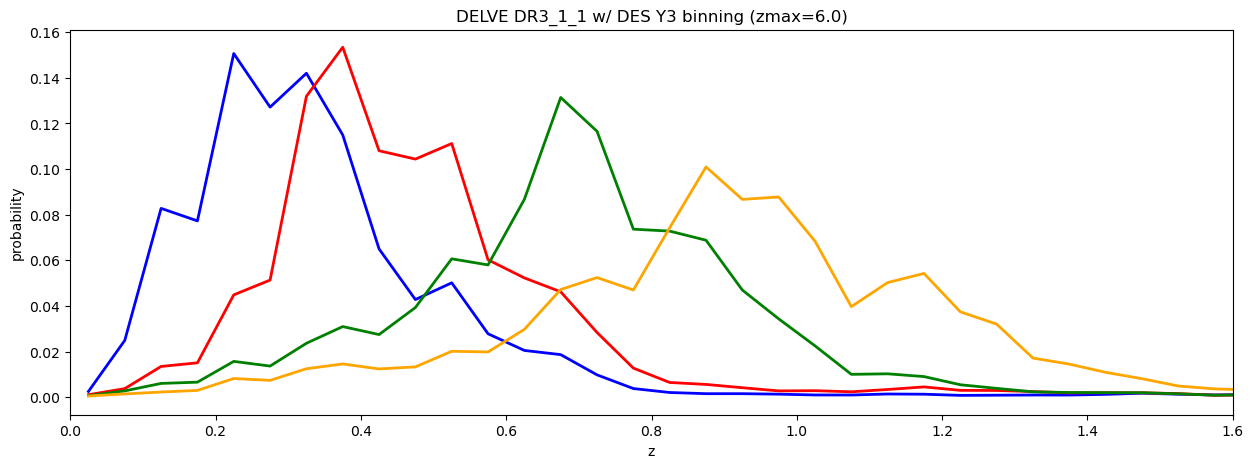

In [ ]:
plt.figure(figsize=(15,5))
plt.title(f'DELVE DR3_1_1 w/ DES Y3 binning (zmax={zmax})')
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('probability')
colors = ['blue', 'red', 'green', 'orange']
plt.xticks(ticks=np.arange(0, 1.9, 0.2))
plt.xlim(0,1.6)
for i in range(n_bins):
    plt.plot(zs, p_z_c_hat_bins[i], c=colors[i], lw=2)
plt.show()

In [83]:
tb_share(bins=bins)

[0.2547063084409846,
 0.19907377365817452,
 0.29387051301159467,
 0.25234940488924623]

### Deep2Wide plots (sanity checks!)

In [69]:
def group_i_deep(i, max_d, n):
    ps = np.array(np.unravel_index(np.arange(0,n**2), (n,n), order='F'))
    p = np.array(np.unravel_index(i, (n,n), order='F'))
    d = np.sum(np.abs(ps-p[:, None]),axis=0)
    return np.arange(0,n**2)[d<=max_d]

In [70]:

fig, axes = plt.subplots(nx, ny, figsize=(12, 24))
i_deeps = np.random.randint(0,n_deep**2, (nx, ny))
for i_deep in i_deeps:

    idx_deep = group_i_deep(i_deep, max_d=2, n=n_deep)

    plt.title(f'Deep SOM cell: {i_deep-1}')

    im = np.sum(p_cchat[:,idx_deep],axis=1).reshape(n_wide,n_wide)

    im /= np.sum(im)

    plt.title(f'Deep SOM cell: {i_deep-1}')
    plt.imshow(im, norm=mpl.colors.LogNorm())
    plt.colorbar()
    plt.show()

NameError: name 'nx' is not defined